In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import sqrt
from copy import deepcopy 
import numpy as np
from pandas import DataFrame, read_csv, Series, to_datetime, concat

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# fix random seed for reproducibility
np.random.seed(7)

/home/matthieu/miniconda3/envs/data51/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data reading and cleaning

In [6]:
data_file = "./data/API_MAR_DS2_en_csv_v2.csv"
data = read_csv(data_file, skiprows=4)

indicator_meaning = data[["Indicator Name", "Indicator Code"]]
data = data.drop(["Country Name", "Country Code", "Indicator Code", "Unnamed: 62"], axis=1)

# transpose dataframe to get years as index
data = data.set_index("Indicator Name").transpose()
data.index.name = "year"

# Drop duplicates columns (like time to start a business male/female)
data = data.T.drop_duplicates().T
# Remove constant columns (ignoring NaNs)
data = data.loc[:,data.apply(Series.nunique) != 1]
# Just look at time series with more than 40 values 
#data = data.loc[:,data.apply(Series.nunique) > 40]

### Univariate training

In [7]:
#Parameters
target_name = "Total fisheries production (metric tons)" #Name of the feature to make a predictor for
max_linked_features = 25 #Set to 0 to make a univariate analysis
fraction_keep_for_test = 0.25 #fraction of the dataset to keep for testing
fraction_look_back = 0.2 #fraction of the dataset used as look_back (TODO: may eventually use a fix number for look_back rather than a fraction)
batch_size = 1 
nb_epochs = 250


ts = data[target_name].dropna()
ts.index = to_datetime(ts.index, format = "%Y")

In [8]:
# Functions definition
# To make it simple to review all function are defined here within 
# the notebook

def check_stationarity(ts, title, xaxis_name='year', yaxis_name=None):
    """ Perform stationarity test and plot rolling stats for visual inspection.
    """
    
    # Naive way to get the yaxis unit from dataset names if not given

    if yaxis_name is None and '(' in title:
        yaxis_name = title.split('(')[1]
    else:
        yaxis_name = ""
        
    #Perform Dickey-Fuller test:
    dftest = adfuller(ts, autolag='AIC')

    # compute rolling mean and standart deviation
    rolmean = ts.rolling(window=8,center=False).mean()
    rolstd = ts.rolling(window=8,center=False).std()

    print(dftest)
    plotly.offline.iplot({
        "data": [
        {
            'x': ts.index,
            'y': ts.values,
            'name': "Travel services values"
        },
        {
            'x': rolmean.index,
            'y': rolmean.values,
            'name': "rolling mean"
        }, 
        {
            'x': rolstd.index,
            'y': rolstd.values,
            'name': "rolling std"
        },

        ],
        "layout": {"title": title,
                   "xaxis": {"title": xaxis_name},
                   "yaxis": {"title": yaxis_name}}
        }
    )
    
    
def features_pick(dataset, feature_name, n_features_max=10) -> list:
    """ 
    Naive way to look for high correlated features 
    that are not inter-correlated
    """
    abs_corr = dataset.corr().abs()
    # get higest corellated feature 
    # (arbitrary cap to .9 as many features really express same informatio)
    selected_features = [abs_corr[feature_name][lambda x: x< .9].idxmax()]
    # pairwise correlation of all features with correlation to target over .7 
    hight_abs_corr = dataset[abs_corr[feature_name][lambda x: x > .7].index].corr().abs()    
    while not len(selected_features) == n_features_max - 1 :
        # select features that have minimum correlations with other selected features (simple additive)
        selected_features.append(hight_abs_corr[selected_features].drop(selected_features).min(axis=1).idxmin())
    return [feature_name] + selected_features


In [9]:
check_stationarity(ts, target_name)

(1.4184980990498388, 0.9971965767706867, 3, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 1133.033171233104)


This timeserie doesn't pass stationarity test. 
The rolling mean show a trend over the period considered.

Although Adam optimiser is supposed to be able to deal with non stationary data it seams to work better with stationary data in this case. 

In [10]:
#differenciate data
diff_data = ts.diff(periods=1)
check_stationarity(diff_data.dropna(), target_name + "after diferenciation", yaxis_name="")

(-6.703595041693989, 3.834383511489575e-09, 2, 52, {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}, 1107.630625797107)


We sucessfully remove the trend and according to the fuller test we can reject the hypothesis of stationarity. 

### Prepare data for supervised model

In [11]:
def prep_ts(data, lag=1):
    """ Prepare TS to treated as a supervised learning problem
    return a DataFrame with TS at t and lagged TS at t+lag.
    """
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# transform data to be supervised learning
data_val = prep_ts(diff_data, 1).values

# split data into train and test-sets
train, test = data_val[0:-10], data_val[-10:]

# transform the scale of the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train) # scaling only on the training data
train_scaled, test_scaled =  scaler.transform(train), scaler.transform(test)

# split into input and outputs
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [12]:
# design network
lstm_model = Sequential()
lstm_model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = lstm_model.fit(train_X, train_y, epochs=100, batch_size=4, validation_data=(test_X, test_y), verbose=0, shuffle=False)


In [13]:
forecast = list()
print(test_scaled)
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    print(X)
    X = X.reshape(1, 1, len(X))
    print(X)
    yhat = lstm_model.predict(X, batch_size=1)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    yhat = yhat + ts.values[-(len(test_scaled)+1-i)]
    
    # store forecast
    predictions.append(yhat)
    expected = ts.values[len(train) + i ]

[[ 0.58834441 -0.69689458]
 [-0.69689458  0.04880183]
 [ 0.04880183  0.61233116]
 [ 0.61233116  0.89276545]
 [ 0.89276545 -0.11255914]
 [-0.11255914 -0.84946112]
 [-0.84946112  1.05620926]
 [ 1.05620926  0.51134977]
 [ 0.51134977  0.58899473]
 [ 0.58899473  0.05570576]]
[0.58834441]
[[[0.58834441]]]
[-0.69689458]
[[[-0.69689458]]]
[0.04880183]
[[[0.04880183]]]
[0.61233116]
[[[0.61233116]]]
[0.89276545]
[[[0.89276545]]]
[-0.11255914]
[[[-0.11255914]]]
[-0.84946112]
[[[-0.84946112]]]
[1.05620926]
[[[1.05620926]]]
[0.51134977]
[[[0.51134977]]]
[0.58899473]
[[[0.58899473]]]


In [14]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    X = X.reshape(1, 1, len(X))
    yhat = lstm_model.predict(X, batch_size=1)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    yhat = yhat + ts.values[-(len(test_scaled)+1-i)]
    
    # store forecast
    predictions.append(yhat)
    expected = ts.values[len(train) + i ]
        

    
# report performance
rmse = sqrt(mean_squared_error(ts.values[-10:], predictions))
persistance_rmse = sqrt(mean_squared_error(ts.values[-10:], ts.values[-11:-1]))
print('Test RMSE: %.3f' % rmse)
print('Persistance RMSE: %.3f' % persistance_rmse)


plotly.offline.iplot({
    "data": [
    {
        'x': ts.index[-10:],
        'y': ts.values[-10:],
        'name': "expected_values"
    },
    {
        'x': ts.index[-10:],
        'y': predictions,
        'name': "walk forward prediction"
    },   
    {
        'x': ts.index[-10:],
        'y': ts.values[-11:-1],
        'name': "persistance"
    },

    ],
    "layout": {"title": target_name,
               "xaxis": {"title": "years"},
               "yaxis": {"title": "metric tons"}}
    }
)

Test RMSE: 124123.562
Persistance RMSE: 125667.224


## Prevision

train_dataset: 42, test_dataset: 19
dataset_size:  56
look_back:  5
train_size:  42
train x: (36, 5, 2)
train y: (36,)
test x: (13, 5, 2)
test y: (13,)
test_predict:  (13, 1)
Train Score: 65764.39 RMSE
Test Score: 114741.23 RMSE


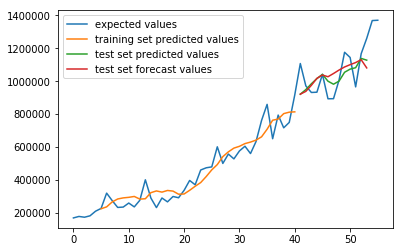

In [3]:
# Total fisheries production (metric tons)

main(target_name="ER.FSH.PROD.MT", 
     max_linked_features=0,
     fraction_keep_for_test=.25, 
     look_back=5, 
     batch_size=2, 
     nb_epochs=100,
     nb_neurons=1, 
     activation='tanh', 
     stateful=True)

### Multivariate forecasting

In [33]:
def features_pick(dataset, feature_name, n_features=10):
    """ Naive way to look for high correlated features 
        that are not inter-correlated
    """
    abs_corr = dataset.corr().abs()
    selected_features = [abs_corr[feature_name][lambda x: (x > .6) & (x< 1)].idxmax()]
    hight_abs_corr = dataset[abs_corr[feature_name][lambda x: x > .7].index].corr().abs()    
    while not len(selected_features) == n_features - 1 :
        selected_features.append(hight_abs_corr[selected_features].drop(selected_features).min(axis=1).idxmin())
    return [feature_name] + selected_features


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# specify the number of lag hours
n_features = 10

target = "Total fisheries production (metric tons)"
selected_features = features_pick(data, target, n_features)
dataset = data[selected_features]
dataset = dataset.dropna(subset = [target])
dataset = dataset.fillna(0)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1).loc[:,:'var1(t)']

# split into train and test sets
values = reframed.values
n_test = 10
train, test = values[:-n_test, :], values[-n_test:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [34]:
plotly.offline.iplot({
    "data": [
    {
        'x': dataset.index,
        'y': dataset[col],
        'name': col[:20]
    }
    for col in dataset],
    "layout": {"title": "Selected features to forecast Total fishries productions",
               "xaxis": {"title": "years"},
               "yaxis": {"title": ""}}
    }
)

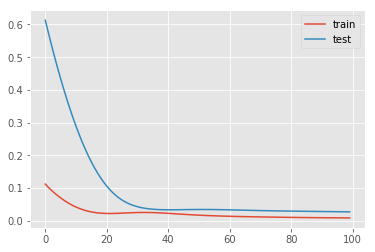

In [35]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [36]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[:-1]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 186140.159


In [37]:
plotly.offline.iplot({
    "data": [
    {
        'x': dataset.index[-10:-1],
        'y': dataset[target].values[-10:-1],
        'name': "expected_values"
    },
    {
        'x': dataset.index[-10:-1],
        'y': inv_yhat[:-1],
        'name': "prediction"
    }, 
    {
        'x': dataset.index[-10:-1],
        'y':  dataset[target].values[-11:-2],
        'name': "persistance"
    },

    ],
    "layout": {"title": target,
               "xaxis": {"title": "years"},
               "yaxis": {"title": "metric tons"}}
    }
)

## Test on a few new target

To make it clearer on the notebook I made a small package called time_series_forecast that old most of the python code. 
Available at https://gitlab.com/matthieu-bernard/test_neural_network


In [2]:
from time_series_forecast.data51 import main

### Proportion of seats held by women in national parliaments

train_dataset: 16, test_dataset: 10
dataset_size:  22
look_back:  4
train_size:  16
train x: (11, 4, 40)
train y: (11,)
test x: (5, 4, 40)
test y: (5,)


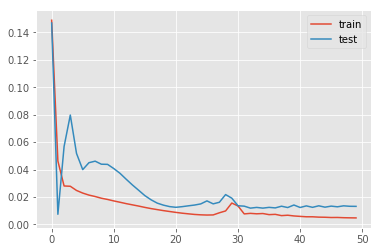

test_predict:  (5, 1)
Train Score: 1.35 RMSE
Test Score: 2.35 RMSE


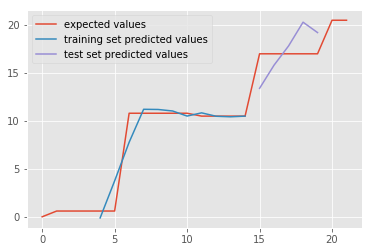

In [79]:
main(target_name="SG.GEN.PARL.ZS", 
     max_linked_features=40,
     fraction_keep_for_test=.25, 
     look_back=4, 
     batch_size=1, 
     nb_epochs=50,
     nb_neurons=50, 
     activation='tanh', 
     stateful=False)

train_dataset: 16, test_dataset: 10
dataset_size:  22
look_back:  4
train_size:  16
train x: (11, 4, 25)
train y: (11,)
test x: (5, 4, 25)
test y: (5,)
test_predict:  (5, 1)
Train Score: 2.11 RMSE
Test Score: 2.64 RMSE


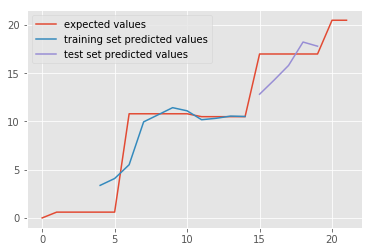

In [71]:
main(target_name="SG.GEN.PARL.ZS", 
     max_linked_features=25,
     fraction_keep_for_test=.25, 
     look_back=4, 
     batch_size=3, 
     nb_epochs=50,
     nb_neurons=50, 
     activation='relu', 
     stateful=True)

 ### Health expenditure

train_dataset: 15, test_dataset: 7
dataset_size:  20
look_back:  2
train_size:  15
train x: (12, 2, 25)
train y: (12,)
test x: (4, 2, 25)
test y: (4,)
test_predict:  (4, 1)
Train Score: 0.18 RMSE
Test Score: 0.36 RMSE


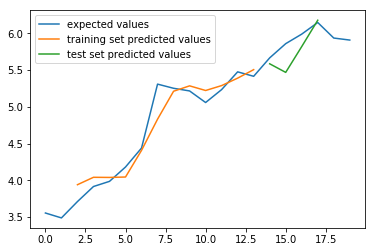

In [19]:
main(target_name="SH.XPD.TOTL.ZS", 
     max_linked_features=25,
     fraction_keep_for_test=.25, 
     look_back=2, 
     batch_size=3, 
     nb_epochs=50,
     nb_neurons=50, 
     activation='tanh', 
     stateful=True)

train_dataset: 15, test_dataset: 8
dataset_size:  20
look_back:  3
train_size:  15
train x: (11, 3, 25)
train y: (11,)
test x: (4, 3, 25)
test y: (4,)


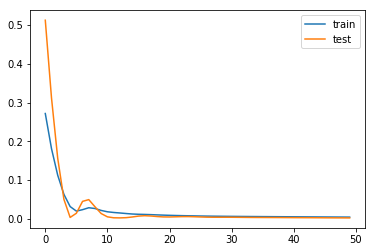

test_predict:  (4, 1)
Train Score: 0.17 RMSE
Test Score: 0.13 RMSE


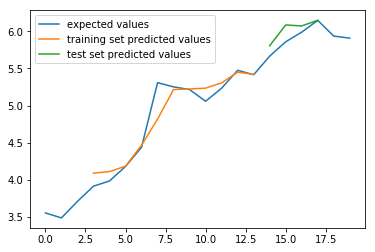

In [22]:
main(target_name="SH.XPD.TOTL.ZS", 
     max_linked_features=25,
     fraction_keep_for_test=.25, 
     look_back=3, 
     batch_size=3, 
     nb_epochs=50,
     nb_neurons=10, 
     activation='linear', 
     stateful=False)